In [1]:
# %matplotlib notebook
# from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from skimage import io, util, transform
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import os

In [2]:
imagenes = []
archivos = os.listdir('imágenes')
for archivo in archivos:
        imagenes.append(io.imread('imágenes/'+archivo))

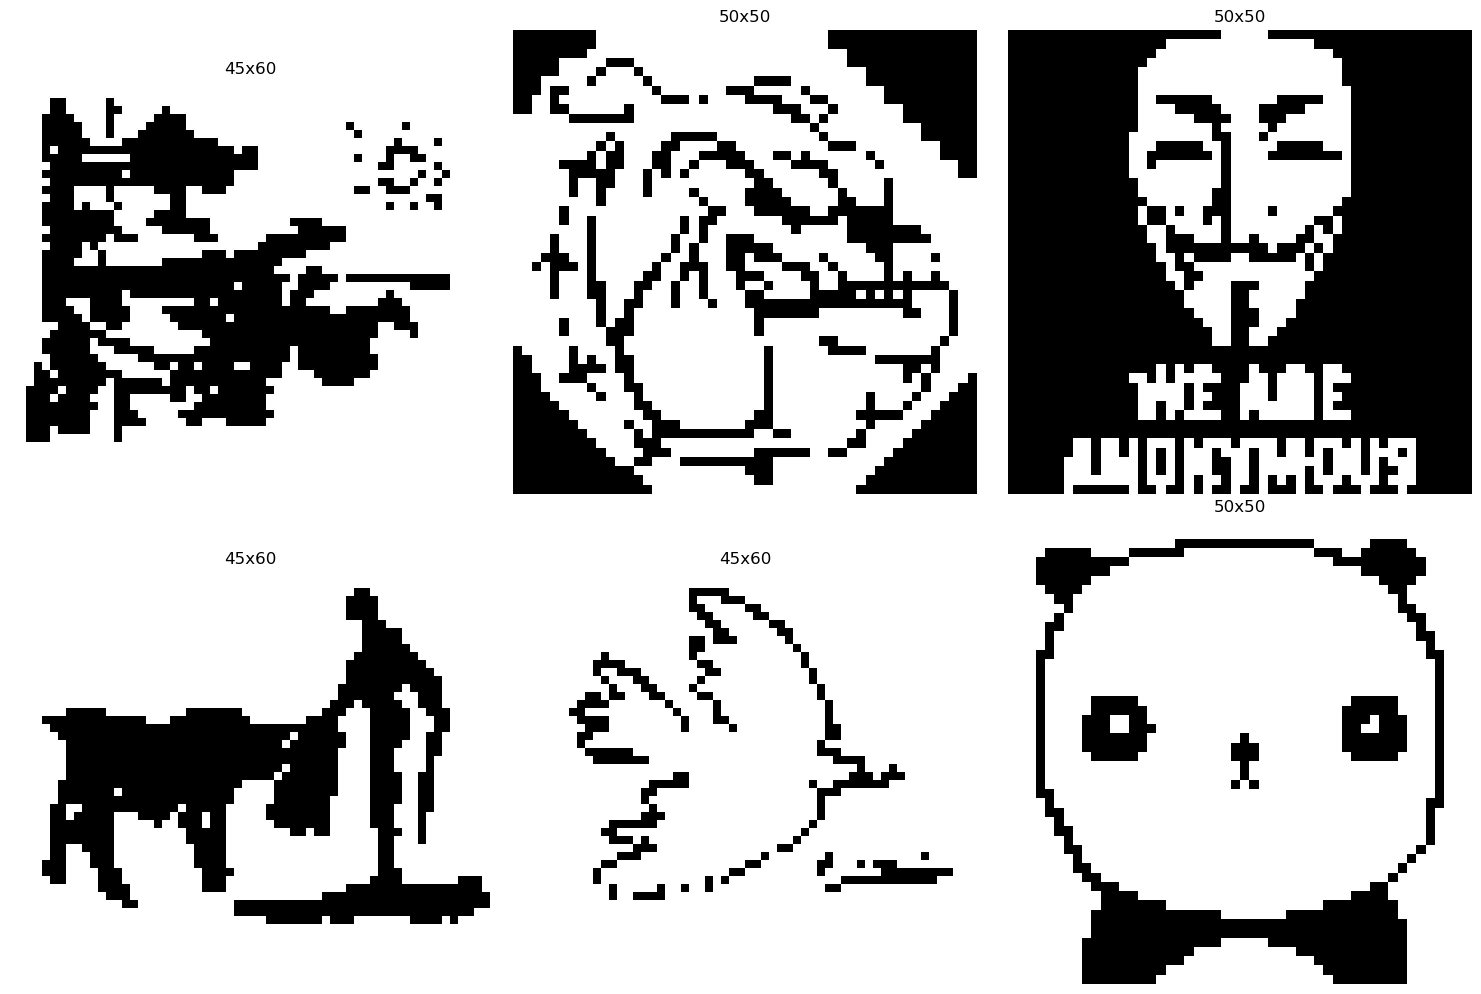

In [3]:
def mostrar_imagenes(imagenes, columnas, mostrar_dimension=False):
    filas = (len(imagenes) + columnas - 1) // columnas

    fig, axes = plt.subplots(filas, columnas, figsize=(15, 5 * filas))

    for i, imagen in enumerate(imagenes):
        ax = axes[i // columnas, i % columnas]
        ax.imshow(imagen, cmap='gray')
        ax.axis('off')
        if mostrar_dimension:
            ax.set_title(str(imagen.shape[0]) + 'x' + str(imagen.shape[1]))

    plt.tight_layout()
    plt.show()

mostrar_imagenes(imagenes, 3, True)

Como las imágenes tienen distintas dimensiones, voy a colocarlas sobre un fondo blanco de la dimensión máxima

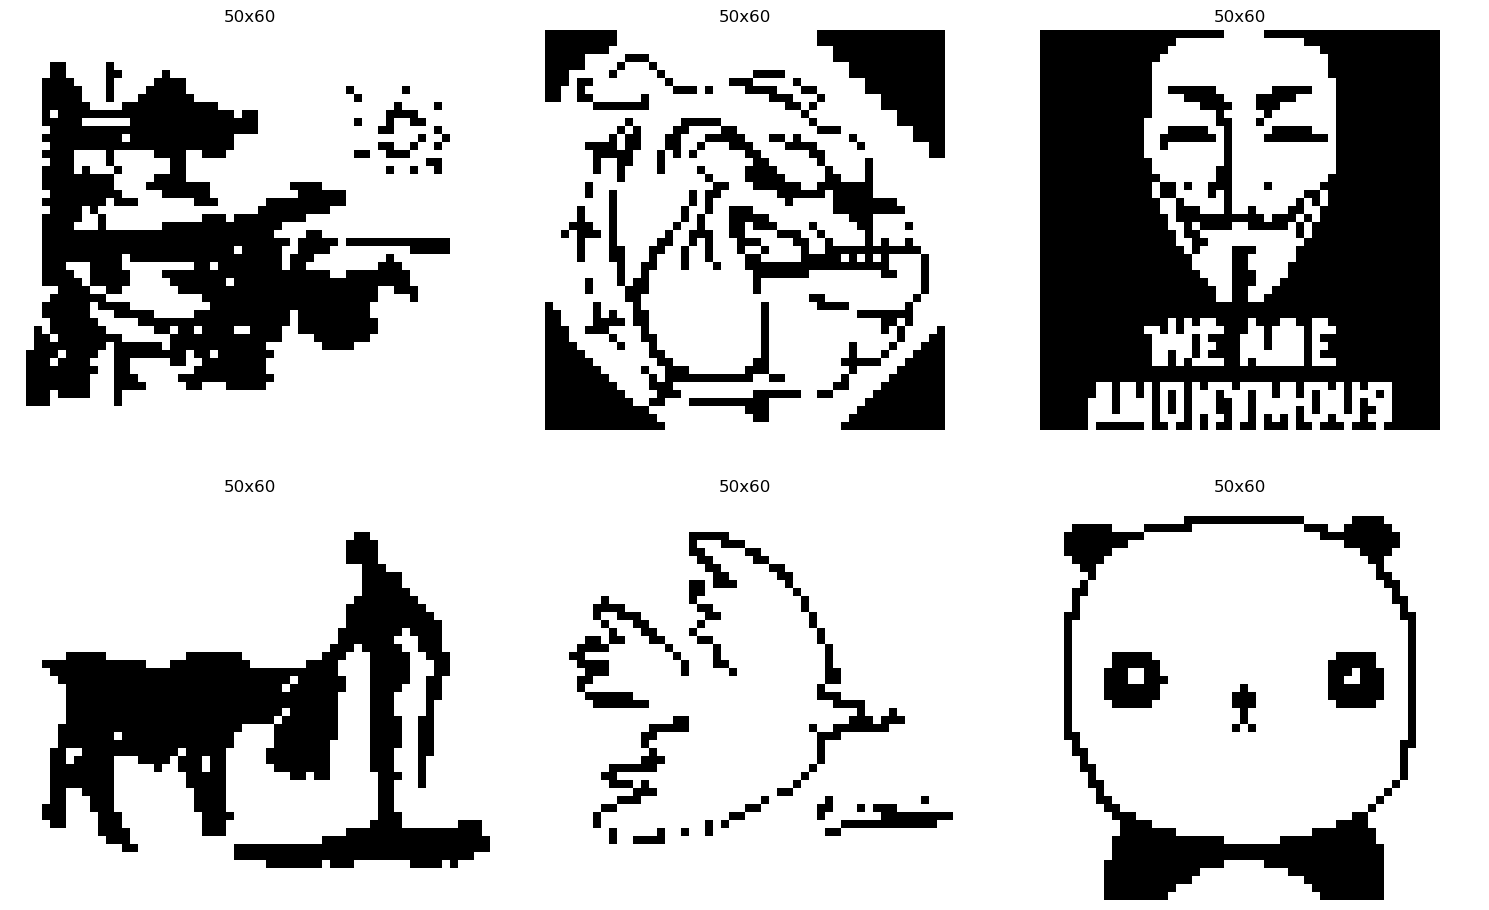

In [4]:
dimensiones = [50, 60]

def redimensionar_imagen(imagen, dimension):
    imagen_rellena = np.ones((dimension[0], dimension[1]), dtype=imagen.dtype)

    offset_y = (dimension[0] - imagen.shape[0]) // 2
    offset_x = (dimension[1] - imagen.shape[1]) // 2

    imagen_rellena[offset_y:offset_y + imagen.shape[0], offset_x:offset_x + imagen.shape[1]] = imagen
    return imagen_rellena

imagenes[:] = [redimensionar_imagen(imagen, dimensiones) for imagen in imagenes]

mostrar_imagenes(imagenes, 3, True)

Modelo de Hopfield: un modelo de memoria asociativa que usa la regla de Hebb para todos los pares $ij$ posibles, con unidades binarias y actualización asíncrona.

Regla de Hebb:
$
w_{ij} = \frac{1}{N} \sum_{\mu=1}^{p} \xi_{i}^{\mu} \xi_{j}^{\mu}
$

In [5]:
class Sinapsis:
    def __init__(self, emisora, receptora, peso):
        self.emisora = emisora
        self.receptora = receptora
        self.peso = peso
    def actualizar_peso(self, peso):
        self.peso = peso

class Neurona:
    def __init__(self):
        self.activacion = 0
        self.sinapsis = []
    def actualizar_activacion(self, activacion):
        self.activacion = activacion
    def agregar_sinapsis(self, receptora, peso):
        self.sinapsis.append(Sinapsis(self, receptora, peso))
    def actualizar_peso_sinapsis(self, receptora, peso):
        for sinapsis in self.sinapsis:
            if sinapsis.receptora == receptora:
                sinapsis.peso = peso
    def obtener_entrada_red(self):
        entrada = 0
        for sinapsis in self.sinapsis:
            entrada += sinapsis.peso * sinapsis.receptora.activacion
        return entrada

def sgn(x):
    return -1 if x < 0 else 1

class Hopfield:
    def __init__(self, cantidad_neuronas):
        self.neuronas = [Neurona() for _ in range(cantidad_neuronas)]
        for emisora in self.neuronas:
            for receptora in self.neuronas:
                if emisora != receptora:
                    emisora.agregar_sinapsis(receptora, 0)

    def entrenar(self, patrones):
        for i in range(len(self.neuronas)):
            for j in range(len(self.neuronas)):
                peso_ij = 0
                for patron in patrones:
                    if i != j:
                        peso_ij += patron[i] * patron[j]
                self.neuronas[i].actualizar_peso_sinapsis(self.neuronas[j], peso_ij)

    def inicializar(self, patron):
        for i in range(len(self.neuronas)):
            self.neuronas[i].activacion = patron[i]

    def recuperar(self, patron, iteraciones=False):
        self.inicializar(patron)
        if iteraciones:
            for _ in range(iteraciones):
                neurona = self.neuronas[random.randint(0, len(self.neuronas)-1)]
                neurona.actualizar_activacion(sgn(neurona.obtener_entrada_red()))
        else:
            configuracion_anterior = 0
            while [neurona.activacion for neurona in self.neuronas] != configuracion_anterior:
                configuracion_anterior = [neurona.activacion for neurona in self.neuronas]
                neurona = self.neuronas[random.randint(0, len(self.neuronas)-1)]
                neurona.actualizar_activacion(sgn(neurona.obtener_entrada_red()))
        return [neurona.activacion for neurona in self.neuronas]

Transformo las imágenes en vectores $\in \{-1, 1\}^{N}$ para poder entrenar a la red

In [6]:
def imagen_a_vector(imagen):
    return np.where(imagen > 0, 1, -1).flatten()

def vector_a_imagen(vector, dimensiones):
    return np.reshape(vector, dimensiones)

patrones = [imagen_a_vector(imagen) for imagen in imagenes] 

In [7]:
hopfield = Hopfield(dimensiones[0]*dimensiones[1])
hopfield.entrenar(patrones)

Ahora pruebo si la red aprendió las imágenes enseñadas, esperando que recupere el mismo input cuando paso como argumento la imagen original

In [8]:
imagenes_recuperadas = []

for imagen in imagenes:
    imagenes_recuperadas.append(hopfield.recuperar(imagen_a_vector(imagen)))

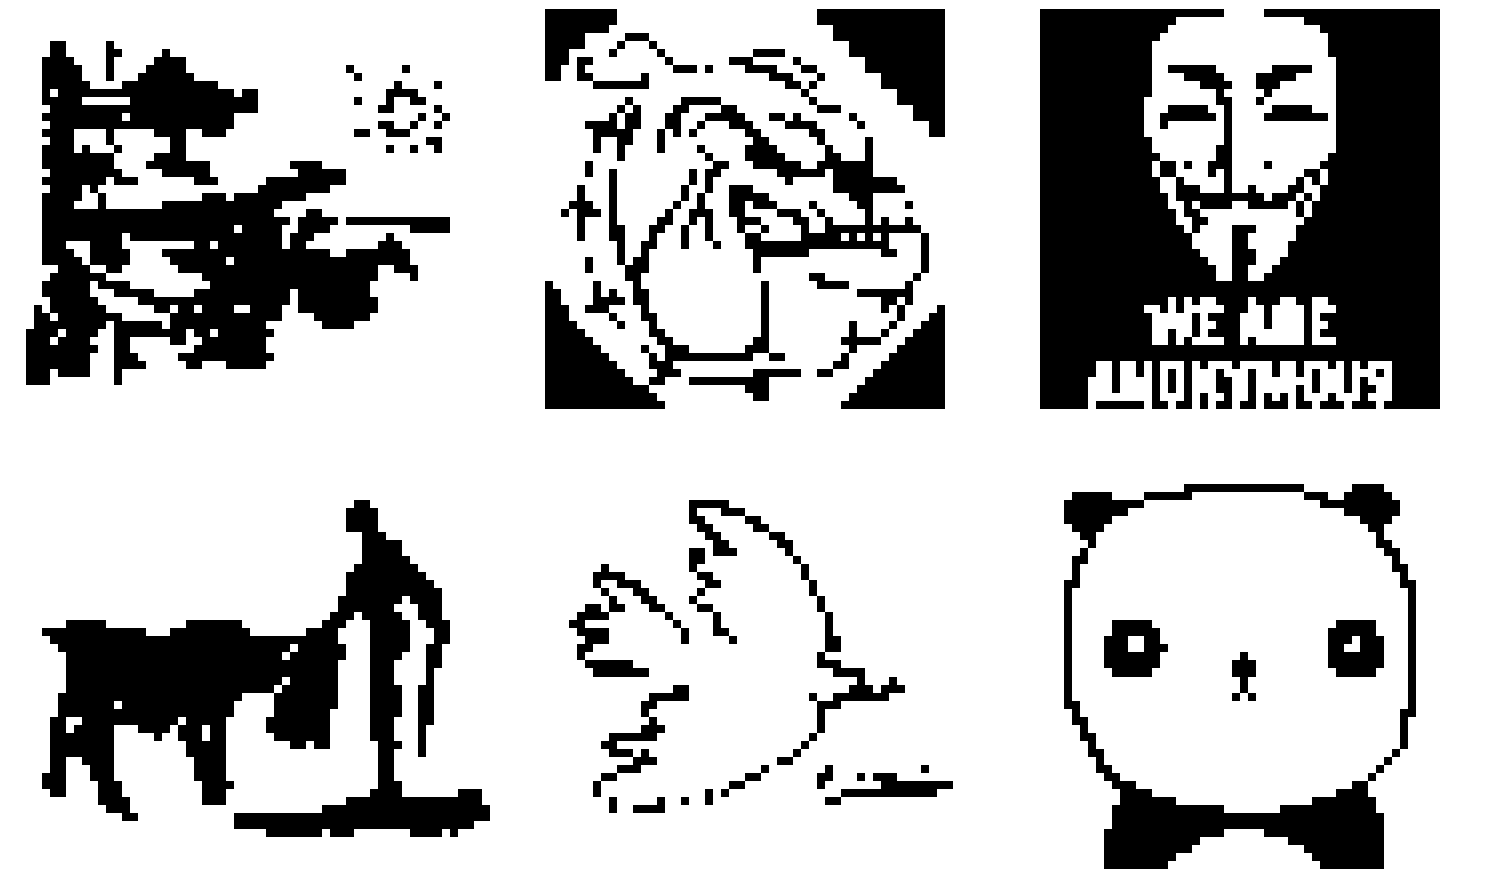

In [9]:
mostrar_imagenes([vector_a_imagen(patron, dimensiones) for patron in patrones], 3)

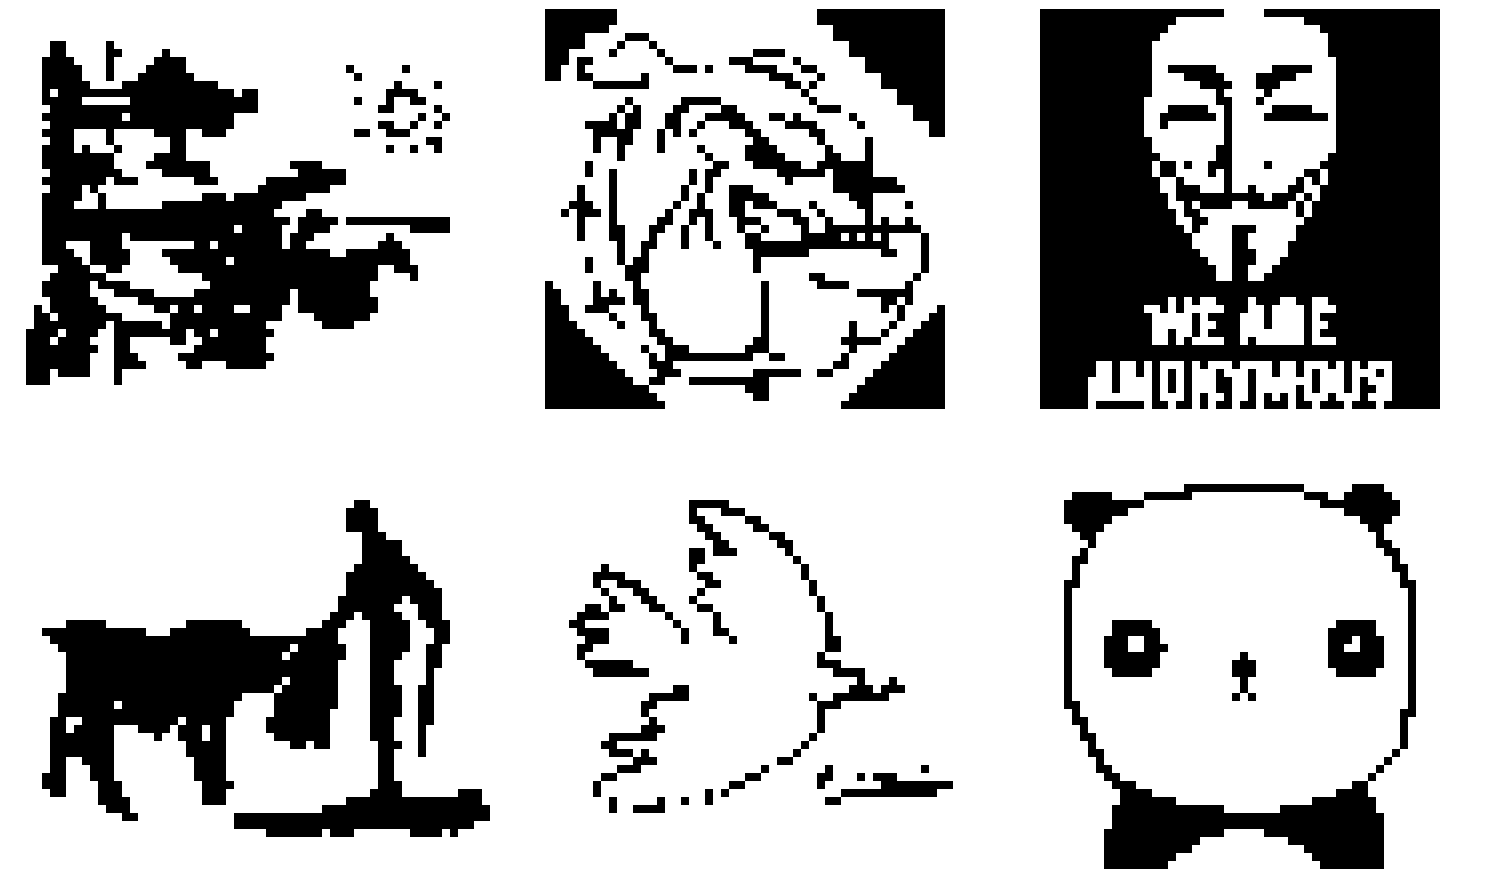

In [10]:
mostrar_imagenes([vector_a_imagen(imagen, dimensiones) for imagen in imagenes_recuperadas], 3)

In [11]:
[(imagenes_recuperadas[i] == patrones[i]).all() for i in range(len(patrones))]

[True, True, True, True, True, True]

Efectivamente, la red converge a las imágenes originales

Ahora agrego ruido a las imágenes para probar si la red puede recuperarlas

In [12]:
def agregar_ruido(imagen, nivel):
    imagen_ruidosa = imagen.copy()
    cantidad_pixeles_corrompidos = int(nivel * imagen.size)
    pixeles_corrompidos = [(random.randint(0, imagen.shape[0]-1), random.randint(0, imagen.shape[1]-1)) for _ in range(cantidad_pixeles_corrompidos)]
    
    for pixel in pixeles_corrompidos:
        imagen_ruidosa[pixel] = 1 if imagen_ruidosa[pixel] == -1 else -1

    return imagen_ruidosa

imagenes_con_ruido = []
imagenes_recuperadas = []

for imagen in imagenes:
    imagenes_con_ruido.append(agregar_ruido(imagen, 0.3))

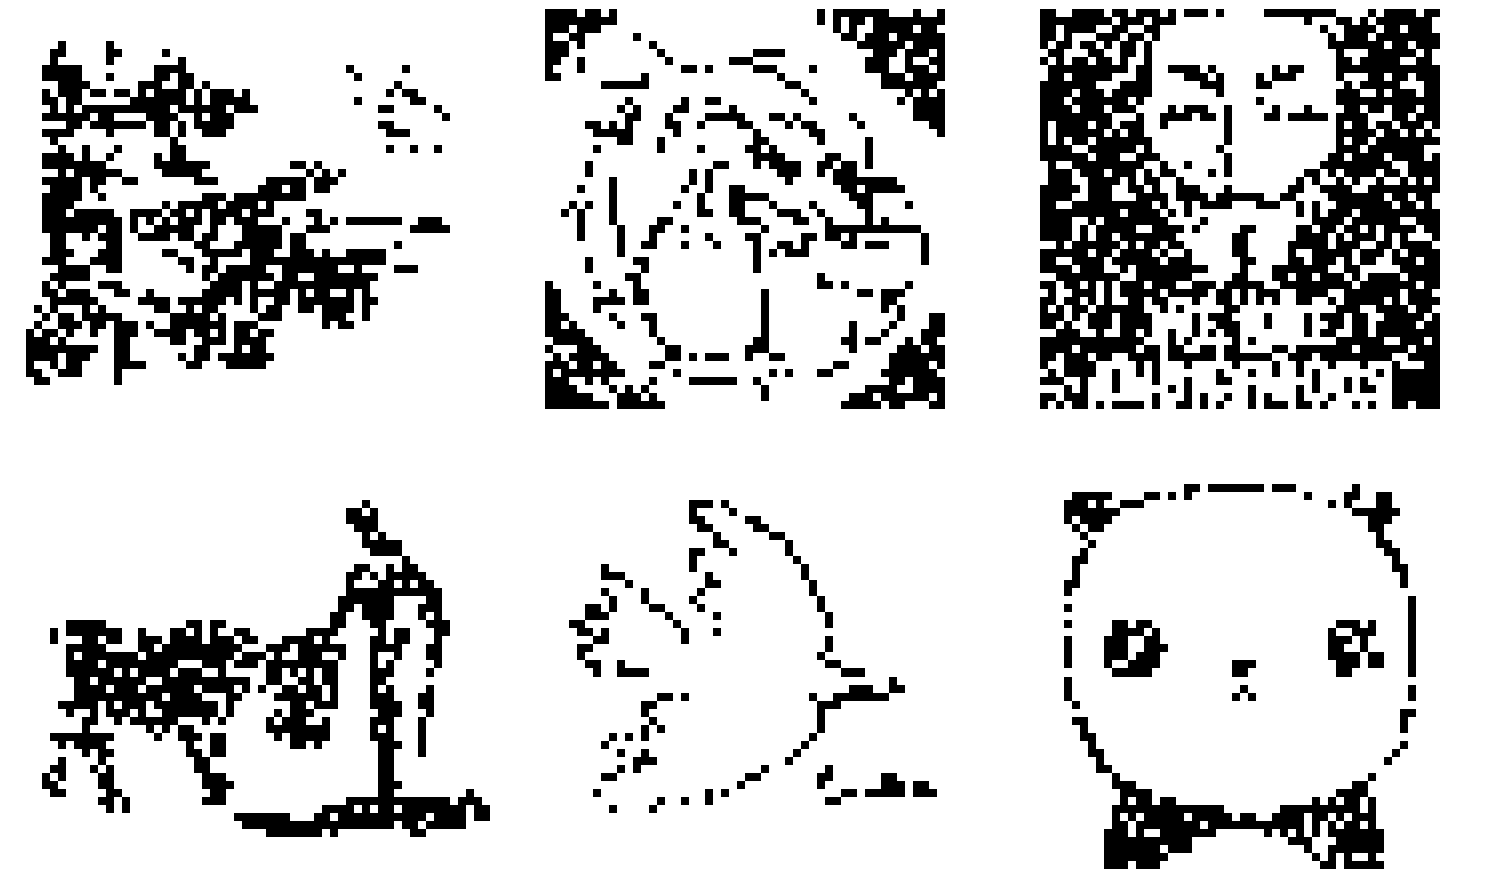

In [13]:
mostrar_imagenes(imagenes_con_ruido, 3)

In [14]:
imagenes_recuperadas = []

for imagen in imagenes_con_ruido:
    imagenes_recuperadas.append(hopfield.recuperar(imagen_a_vector(imagen)))

In [15]:
[(imagenes_recuperadas[i] == patrones[i]).all() for i in range(len(patrones))]

[False, False, False, False, False, False]

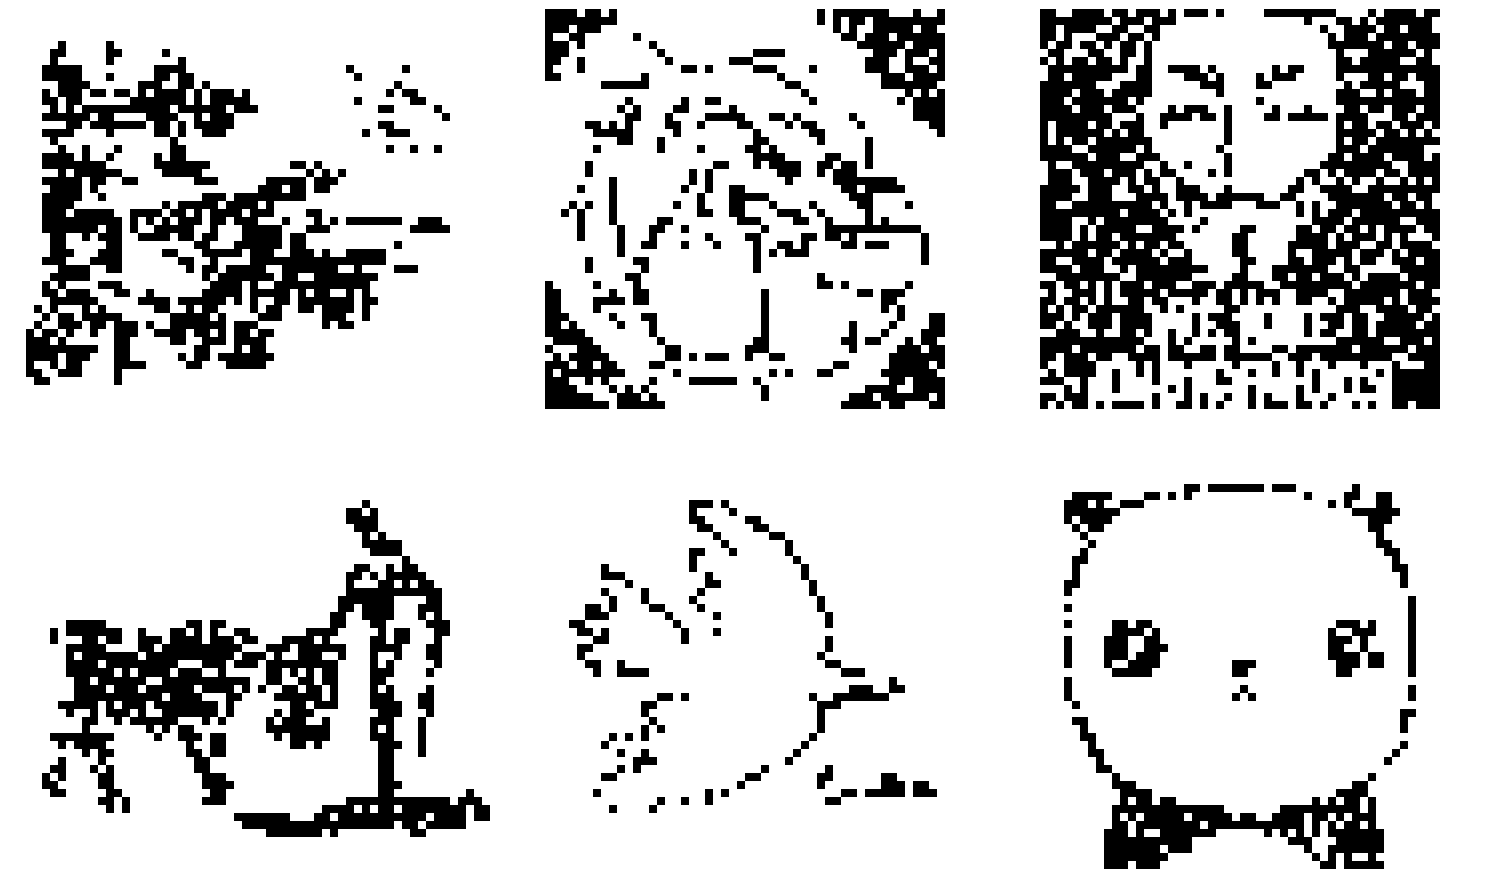

In [16]:
mostrar_imagenes([vector_a_imagen(imagen, dimensiones) for imagen in imagenes_recuperadas], 3)

Pruebo la convergencia eliminando elementos de las imágenes

In [17]:
def remover_elementos(imagen, nivel):
    imagen_con_elementos_removidos = imagen.copy()
    area_cuadrado = int(nivel * imagen.shape[0] * imagen.shape[1])

    lado_cuadrado = int(np.sqrt(area_cuadrado))

    posicion_y = random.randint(0, imagen.shape[0] - lado_cuadrado)
    posicion_x = random.randint(0, imagen.shape[1] - lado_cuadrado)

    imagen_con_elementos_removidos[posicion_y:posicion_y + lado_cuadrado, posicion_x:posicion_x + lado_cuadrado] = 1
    
    return imagen_con_elementos_removidos

imagenes_con_elementos_removidos = [remover_elementos(imagen, 0.01) for imagen in imagenes]

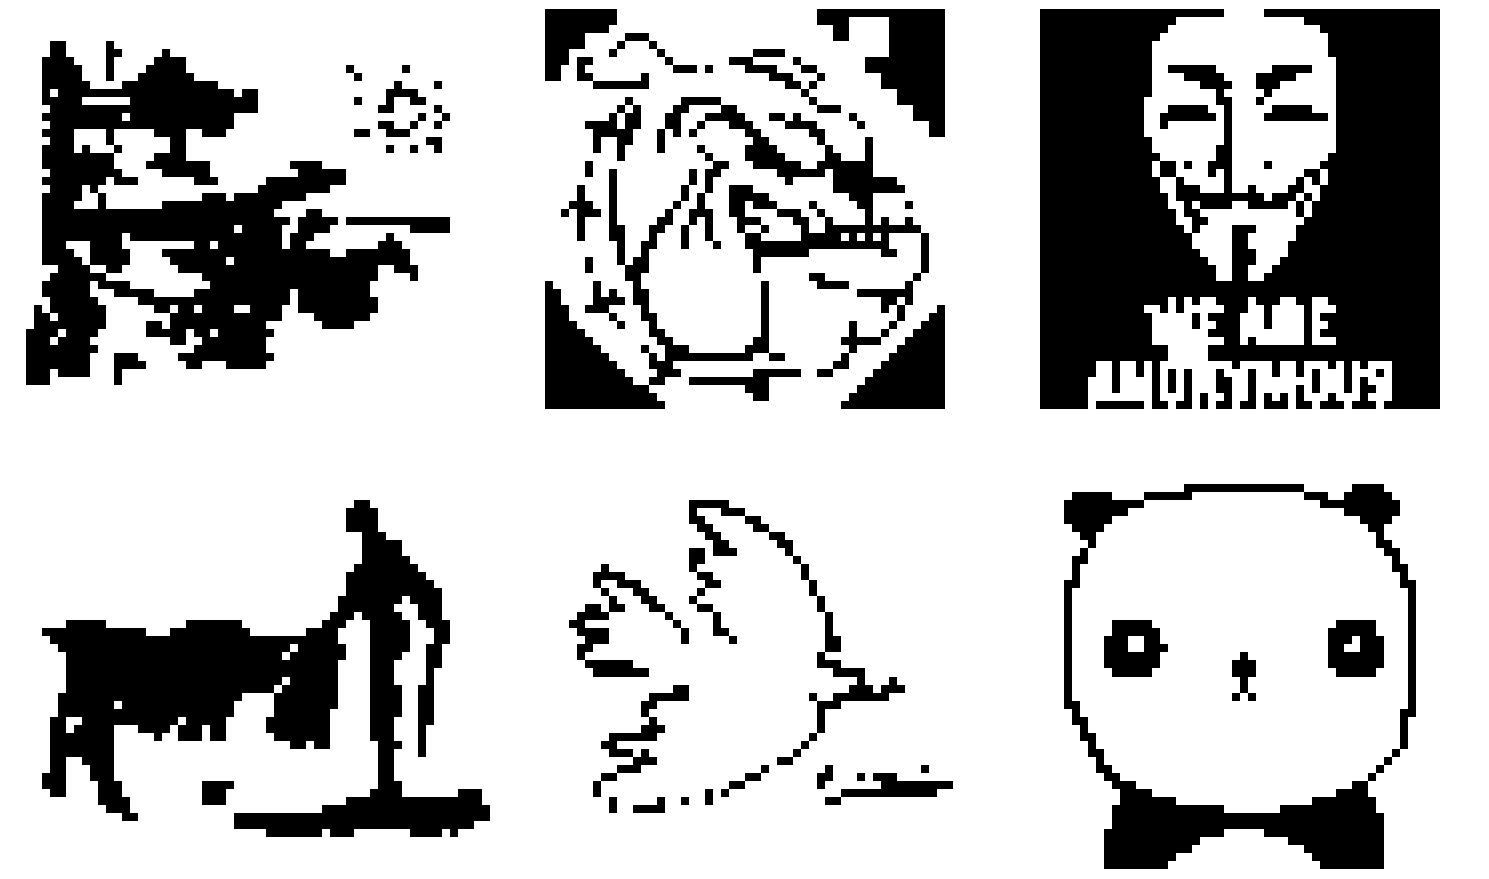

In [18]:
mostrar_imagenes(imagenes_con_elementos_removidos, 3)

In [19]:
imagenes_recuperadas = []

for imagen in imagenes_con_elementos_removidos:
    imagenes_recuperadas.append(hopfield.recuperar(imagen_a_vector(imagen)))

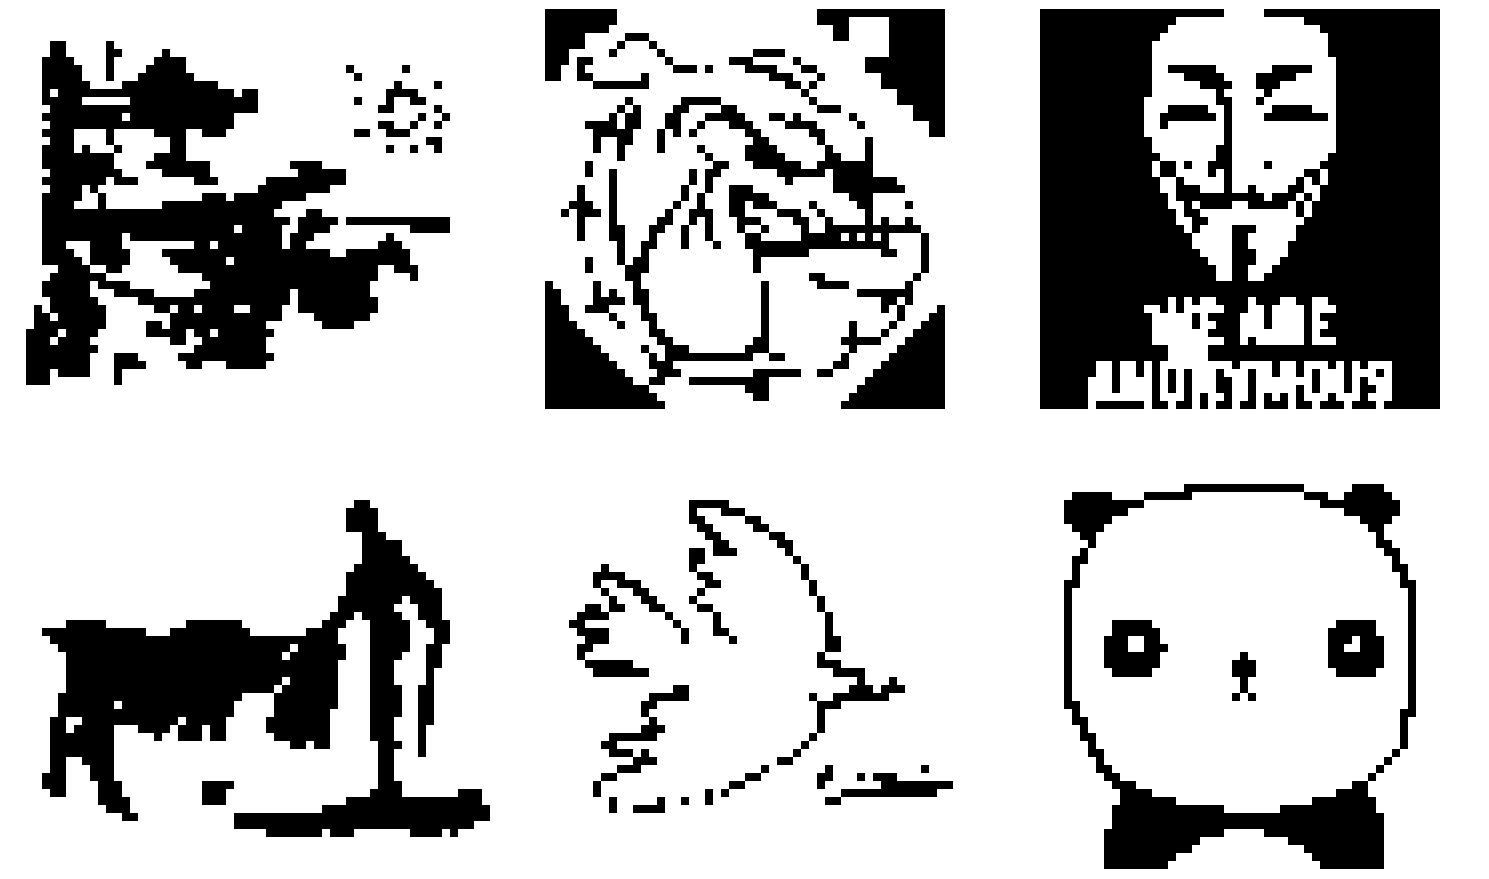

In [20]:
mostrar_imagenes([vector_a_imagen(imagen, dimensiones) for imagen in imagenes_recuperadas], 3)

La red no puede aprender bien los seis patrones. Esto se debe a un punto débil de Hopfield: su capacidad de almacenamiento, que evidentemente, es excedida con seis patrones

Veamos que pasa si restamos patrones del entrenamiento

In [21]:
hopfield = Hopfield(dimensiones[0]*dimensiones[1])
hopfield.entrenar(patrones[:2])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

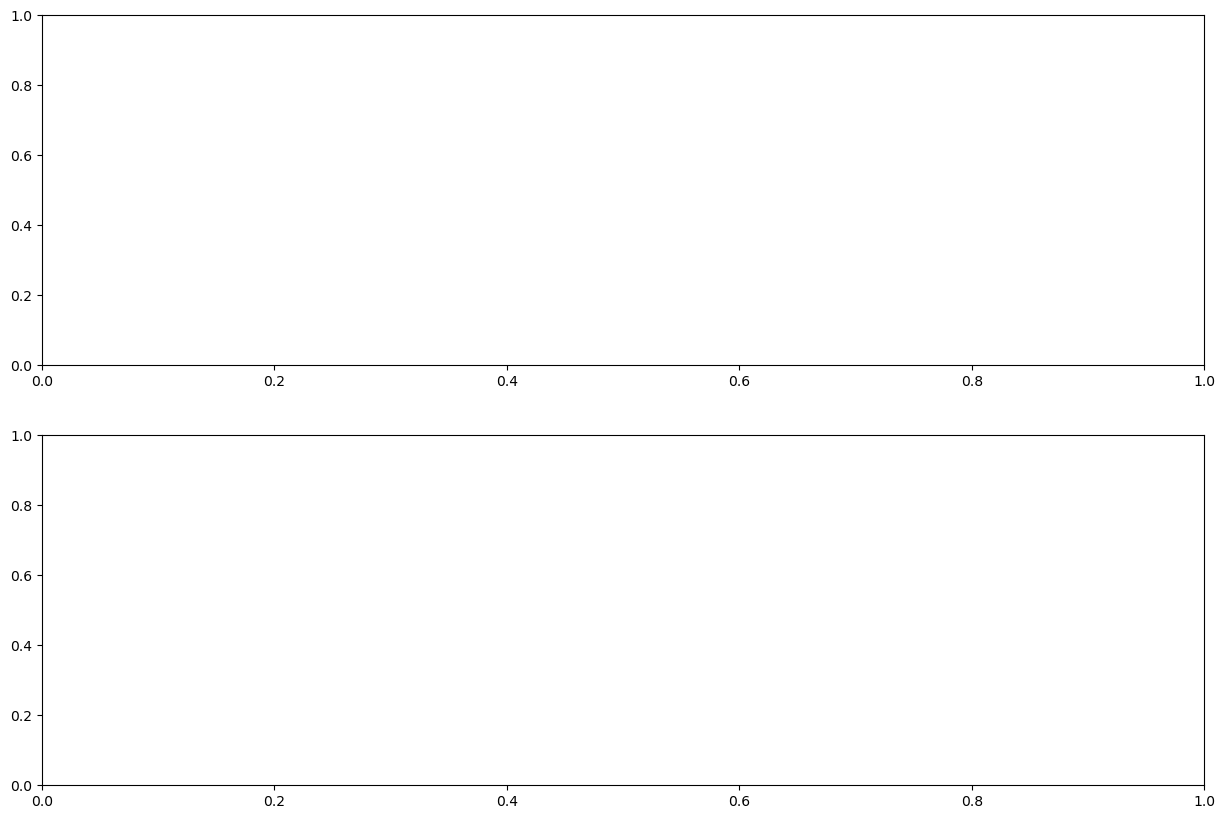

In [22]:
mostrar_imagenes([vector_a_imagen(hopfield.recuperar(patron), dimensiones) for patron in patrones[:2]], 1)

Era de esperar que la red pudiera aprender bien tres imágenes si ya había podido con seis, pero ¿qué pasa si las adulteramos?

Les agrego ruido:

In [ ]:
imagenes_con_ruido = [agregar_ruido(imagen, 0.2) for imagen in imagenes[:2]]

mostrar_imagenes(imagenes_con_ruido, 1)

In [ ]:
imagenes_recuperadas = [vector_a_imagen(hopfield.recuperar(imagen_a_vector(imagen)), dimensiones) for imagen in imagenes_con_ruido]

mostrar_imagenes(imagenes_recuperadas, 1)